### Load the required packages

In [4]:
from model.Build_Model import dffROIModel
from train.Evaluation_Metrics import TPR,FPR
from train.Train_Model import train
import numpy as np
from kpic2.kpic_process import data_transform,get_kpic_roi, model_process
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from tensorflow.keras.models import load_model
from model.data_process import randomize
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns 
from sklearn.linear_model import LinearRegression

In [5]:
def get_component(X):
    svd = np.linalg.svd(X)
    y = svd[1].reshape(len(svd[1]),1)
    x = np.linspace(0,X.shape[0]-1,X.shape[0]).reshape(X.shape[0],1)
    model = LinearRegression()
    model = model.fit(x[12:,:], y[12:,:])
    y2 = model.predict(x)
    plt.scatter(x, y, c = 'r',marker='.',label = 'raw')
    plt.plot(x,y2,c = 'b',label = 'Regression')
    plt.xlabel('Number of component')
    plt.ylabel('Eigenvalues')
    plt.legend()
    c = max([i for i in range(12) if y[i] > y2[i]])
    return c

### Import the functions in KPIC2 to implement the whole process of metabolomics processing

In [6]:
numpy2ri.activate()
robjects.r('''source('kpic2/kpic_process.R')''')
kpic_pic = robjects.globalenv['kpic_pic']
kpic_pic_set = robjects.globalenv['kpic_pic_set']
kpic_pic_getpeak = robjects.globalenv['kpic_pic_getpeak']
kpic_group = robjects.globalenv['kpic_group']
kpic_iso = robjects.globalenv['kpic_iso']
kpic_mat = robjects.globalenv['kpic_mat']
kpic_fill = robjects.globalenv['kpic_fill']
kpic_pattern = robjects.globalenv['kpic_pattern']
kpic_select = robjects.globalenv['kpic_select']

### Read example data and divide training set and validation set. 
#### The training example data is just an example to illustrate the training process. If you want to get the complete data, you can contact the author of peakonly. 

In [31]:
x1 = np.load('example/x1.npy')
x2 = np.load('example/x2.npy')
label = np.load('example/label.npy')
x1,x2,label = randomize(x1, x2,label)
x_train = x1[0:320,:,:]
x_ver = x1[320:400,:,:]
x2_train = x2[0:320,:,:]
x2_ver = x2[320:400,:,:]
y_train = label[0:320,:]
y_ver = label[320:400,:]

### Train dffROI model by using example data

In [32]:
epochs = 20
batch_size = 10
dffROI_model = dffROIModel()
dffROI_model,history_dict = train(dffROI_model,x_train, x2_train, y_train,x_ver,x2_ver, y_ver,
      epochs,batch_size)

Epoch 1/20
32/32 [==============================] - 1s 15ms/step - loss: 0.6971 - binary_accuracy: 0.3743 - TPR: 0.0533 - FPR: 0.0047 - val_loss: 0.6857 - val_binary_accuracy: 0.7625 - val_TPR: 0.7066 - val_FPR: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 0s 10ms/step - loss: 0.6810 - binary_accuracy: 0.7116 - TPR: 0.6497 - FPR: 0.2228 - val_loss: 0.6220 - val_binary_accuracy: 0.8625 - val_TPR: 0.9683 - val_FPR: 0.5000
Epoch 3/20
32/32 [==============================] - 0s 9ms/step - loss: 0.6170 - binary_accuracy: 0.7204 - TPR: 0.9563 - FPR: 0.7439 - val_loss: 0.4568 - val_binary_accuracy: 0.8500 - val_TPR: 0.9169 - val_FPR: 0.2917
Epoch 4/20
32/32 [==============================] - 0s 10ms/step - loss: 0.4773 - binary_accuracy: 0.8160 - TPR: 0.8915 - FPR: 0.3435 - val_loss: 0.3320 - val_binary_accuracy: 0.8625 - val_TPR: 0.8534 - val_FPR: 0.0833
Epoch 5/20
32/32 [==============================] - 0s 9ms/step - loss: 0.4264 - binary_accuracy: 0.7771 - TPR: 0.8259 - 

### Extract PICs using KPIC2

In [40]:
filename = 'E:/evaluation/MTBLS120/pos'
pics = kpic_pic_set(filename,level = 3000)

### Use dffROI  to get false positive PICs

In [46]:
pics2 = list(pics)
pics3 = [data_transform(i) for i in pics2]
pics4 = get_kpic_roi(pics3)
result = model_process(dffROI_model,pics4)

### Filter false positive PICs

In [47]:
del_list = []
for d in range(len(result)):
    d0 = kpic_select(result[d],pics2[d])
    del_list.append(d0)
del_rlist = robjects.ListVector([(str(i), x) for i, x in enumerate(del_list)])

### Extract peaks on PICs

In [48]:
del_rlist = kpic_pic_getpeak(del_rlist)

### The peak table is obtained by processing the features using methods such as grouping, align, isotope removal, and missing value filling in KPIC2

In [49]:
groups_align = kpic_group(del_rlist)
groups_align = kpic_iso(groups_align)
data = kpic_mat(groups_align)
data = kpic_fill(data)
data = list(data)
data[3] = np.array(data[3])
df = np.array(data[3])

filling peaks of E:/evaluation/MTBLS120/pos/130615_Pos_115_1A.CDF 


R[write to console]: Loading required package: Rcpp



filling peaks of E:/evaluation/MTBLS120/pos/130615_Pos_115_1B.CDF 
filling peaks of E:/evaluation/MTBLS120/pos/130615_Pos_115_1C.CDF 
filling peaks of E:/evaluation/MTBLS120/pos/130615_Pos_115_2A.CDF 
filling peaks of E:/evaluation/MTBLS120/pos/130615_Pos_115_2B.CDF 
filling peaks of E:/evaluation/MTBLS120/pos/130615_Pos_115_2C.CDF 
filling peaks of E:/evaluation/MTBLS120/pos/130615_Pos_115_3A.CDF 
filling peaks of E:/evaluation/MTBLS120/pos/130615_Pos_115_3B.CDF 
filling peaks of E:/evaluation/MTBLS120/pos/130615_Pos_115_3C.CDF 
filling peaks of E:/evaluation/MTBLS120/pos/130615_Pos_120_1A.CDF 
filling peaks of E:/evaluation/MTBLS120/pos/130615_Pos_120_1B.CDF 
filling peaks of E:/evaluation/MTBLS120/pos/130615_Pos_120_1C.CDF 
filling peaks of E:/evaluation/MTBLS120/pos/130615_Pos_120_2A.CDF 
filling peaks of E:/evaluation/MTBLS120/pos/130615_Pos_120_2B.CDF 
filling peaks of E:/evaluation/MTBLS120/pos/130615_Pos_120_2C.CDF 
filling peaks of E:/evaluation/MTBLS120/pos/130615_Pos_120_3A.

### Data set partitioning for PLS-DA modeling and determining the number of principal components

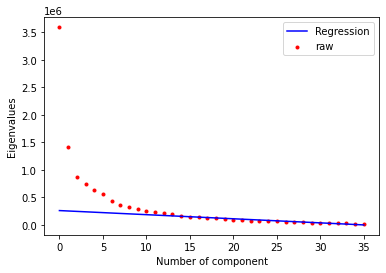

In [50]:
X = df[6:,:]
y1 = np.zeros((9,1))
y2 = 1*np.ones((9,1))
y3 = 2*np.ones((9,1))
y4 = 3*np.ones((9,1))
y = np.vstack((y1,y2,y3,y4))
Y = y.ravel()
Y = pd.get_dummies(Y)
train_X,test_X, train_y, test_y = train_test_split(X,  Y, test_size=0.3)
n_components = get_component(X)

### Build the PLS-DA model and test the model performance on the test set. The results are displayed with a confusion matrix

<AxesSubplot:>

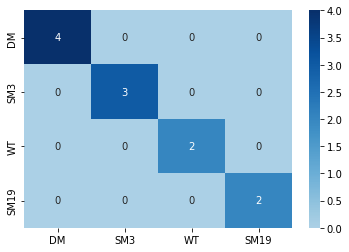

In [51]:
model = PLSRegression(n_components)
model.fit(train_X,train_y)
y_pred = model.predict(test_X)
y_pred = np.array([np.argmax(i) for i in y_pred])
test_y = np.array([np.argmax(test_y.iloc[i,:]) for i in range(test_y.shape[0])])
yp = model.predict(X)
yp = np.array([np.argmax(i) for i in yp])
yt = y.ravel()  
test_mat = confusion_matrix(test_y,y_pred,labels=[0,1,2,3])
test_mat = pd.DataFrame(test_mat)
test_mat.columns = ['DM','SM3','WT','SM19']
test_mat.index = ['DM','SM3','WT','SM19']
sns.heatmap(test_mat,annot=True,center = 1,cmap="Blues")